Install required packages

In [ ]:
                                                                                                            # Step 1: Install required package
!pip install wfdb
!pip install numpy pandas matplotlib scikit-learn tensorflow
#!pip install torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


Mount Google Drive

In [ ]:
# %%
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [ ]:



import wfdb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight # Import class_weight
import tensorflow as tf # Import tensorflow
import glob # Ensure glob is imported early if not already



Define data folder path

In [ ]:
# %%
# Step 4: Define your data folder path
base = '/content/drive/MyDrive/leipzig-heart-center-ecg-database-arrhythmias-in-children-and-patients-with-congenital-heart-disease-1.0.0'
folder_path = base


try:
    child_info = pd.read_csv(f'{base}/children-subject-info.csv')
    adult_info = pd.read_csv(f'{base}/adults-subject-info.csv')
    dataset_info = pd.read_csv(f'{base}/dataset_info.csv')
    print("Metadata loaded.")
except FileNotFoundError:
    child_info = adult_info = dataset_info = None
    print("Metadata files not found; skipping.")

Metadata loaded.


# Visulizaiton

In [ ]:

rec_names = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(folder_path, '*.dat'))]
all_ann_symbols = []

# You might want to process a larger subset than just the first 20 if possible
# This loop iterates through the record names you've already loaded
print("Analyzing annotation distribution (processing  records)...")
for rec in rec_names[:20]: # Processing first 20 records for efficiency, adjust if needed
    path = os.path.join(folder_path, rec)
    try:
        # Load annotations
        annotation = wfdb.rdann(path, 'atr') # Assuming 'atr' is the annotation extension
        all_ann_symbols.extend(annotation.symbol)
    except FileNotFoundError:
        # Handle cases where annotation file might be missing
        print(f"Annotation file not found for {rec}. Skipping.")
        continue
    except Exception as e:
        print(f"Error loading annotation for {rec}: {e}")
        continue

if all_ann_symbols:
    # Count the occurrences of each symbol
    symbol_counts = pd.Series(all_ann_symbols).value_counts()
    print("\nAnnotation Symbol Distribution ( records):")
    print(symbol_counts)
else:
    print("\nNo annotations found in the processed records.")

# %%
# Explore the loaded metadata DataFrames

print("\nChildren Subject Info:")
if child_info is not None:
    display(child_info.head()) # Display the first few rows
    print("\nChildren Subject Info Shape:", child_info.shape)
    print("\nChildren Subject Info Columns:\n", child_info.columns)
else:
    print("Children subject info not loaded.")

print("\nAdults Subject Info:")
if adult_info is not None:
    display(adult_info.head()) # Display the first few rows
    print("\nAdults Subject Info Shape:", adult_info.shape)
    print("\nAdults Subject Info Columns:\n", adult_info.columns)
else:
    print("Adults subject info not loaded.")

print("\nDataset Info:")
if dataset_info is not None:
    display(dataset_info.head()) # Display the first few rows
    print("\nDataset Info Shape:", dataset_info.shape)
    print("\nDataset Info Columns:\n", dataset_info.columns)
else:
    print("Dataset info not loaded.")

# You can add more analysis of the metadata DataFrames here,
# e.g., checking unique values in columns, looking at value counts for categorical columns, etc.

# %%
# Check properties of a sample record

if rec_names:
    sample_rec_name = rec_names[0] # Choose one of the loaded record names
    sample_record_path = os.path.join(folder_path, sample_rec_name)
    try:
        sample_record = wfdb.rdrecord(sample_record_path)
        print(f"\nProperties of sample record '{sample_rec_name}':")
        print("  Sampling Frequency (Hz):", sample_record.fs)
        print("  Number of Signals:", sample_record.n_sig)
        print("  Signal Names:", sample_record.sig_name)
        print("  Signal Units:", sample_record.units)
        print("  Signal Length (samples):", sample_record.sig_len)
        print("  Record Length (seconds):", sample_record.sig_len / sample_record.fs)

        # Optionally, display annotation details for the sample record
        try:
            sample_ann = wfdb.rdann(sample_record_path, 'atr')
            print("\n  Sample Annotations (first 10):")
            for i in range(min(10, len(sample_ann.sample))):
                print(f"    Sample: {sample_ann.sample[i]}, Symbol: {sample_ann.symbol[i]}, Aux: {sample_ann.aux_note[i] if sample_ann.aux_note else 'N/A'}")
        except FileNotFoundError:
             print("\n  No annotation file found for this sample record.")

    except Exception as e:
        print(f"\nError reading sample record {sample_rec_name}: {e}")
else:
    print("\nNo record names available to check sample record properties.")

Analyzing annotation distribution (processing  records)...

Annotation Symbol Distribution ( records):
X    14979
N    13477
R     5989
/     4051
V      992
+      826
Q      307
A      109
a       93
F       90
J       59
~       56
f       26
b        1
Name: count, dtype: int64

Children Subject Info:


,subject_id,file_name,gender,age,diagnosis,ap_loacation,ecg_duration
0,1,x001,M,6.6,AVRT,right posteroseptal,2:25:29.201
1,2,x002,M,11,AVNRT,NaN,1:45:17.81
2,3,x003,F,11.9,AVRT-WPW,left lateral,2:30:31.749
3,4,x004,M,14.8,AVRT-WPW,right posterior,2:17:52.426
4,5,x005,M,17.1,AVRT,left anterior,0:30:58.974



Children Subject Info Shape: (29, 7)

Children Subject Info Columns:
 Index(['subject_id', 'file_name', 'gender', 'age', 'diagnosis', 'ap_loacation',
       'ecg_duration'],
      dtype='object')

Adults Subject Info:


,subject_id,file_name,gender,age,diagnosis,ecg_duration
0,100,x100,M,64.16,TOF with VT,0:13:2.107
1,101,x101,M,29.05,TOF with VT,0:17:51.82
2,102,x102,F,54.35,TOF without VT,0:28:26.809
3,103,x103,F,21.68,TOF with nsVT,0:18:59.532
4,104,x104,M,35.24,TOF with VT,0:57:27.091



Adults Subject Info Shape: (10, 6)

Adults Subject Info Columns:
 Index(['subject_id', 'file_name', 'gender', 'age', 'diagnosis',
       'ecg_duration'],
      dtype='object')

Dataset Info:


,abbreviation,dataset_symbol,dataset_aux_string,description
0,aAVNRT,X,avnrt,Aberrated AVNRT
1,aAVRT,X,avrt,Aberrated AVRT
2,ABL12,NaN,NaN,Ablation and mapping catheter (distal electrodes)
3,AF,X,AFIB,Atrial Fibrillation
4,AFL,X,AFL,Atrial Flutter



Dataset Info Shape: (55, 4)

Dataset Info Columns:
 Index(['abbreviation', 'dataset_symbol', 'dataset_aux_string', 'description'], dtype='object')

Properties of sample record 'x008':
  Sampling Frequency (Hz): 977
  Number of Signals: 19
  Signal Names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'ABL12', 'RVA12', 'CS12', 'CS34', 'CS56', 'CS78', 'CS90']
  Signal Units: ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV']
  Signal Length (samples): 430270
  Record Length (seconds): 440.39918116683725

  Sample Annotations (first 10):
    Sample: 245, Symbol: +, Aux: (AVRT
    Sample: 405, Symbol: X, Aux: AVRT
    Sample: 816, Symbol: X, Aux: AVRT
    Sample: 1230, Symbol: X, Aux: AVRT
    Sample: 1603, Symbol: X, Aux: AVRT
    Sample: 2014, Symbol: X, Aux: AVRT
    Sample: 2406, Symbol: X, Aux: AVRT
    Sample: 2825, Symbol: X, Aux: AVRT
    Sample: 3195, Symbol: X, Aux: AVRT
    Sample: 3620

Load and Plot Sample ECG Signal

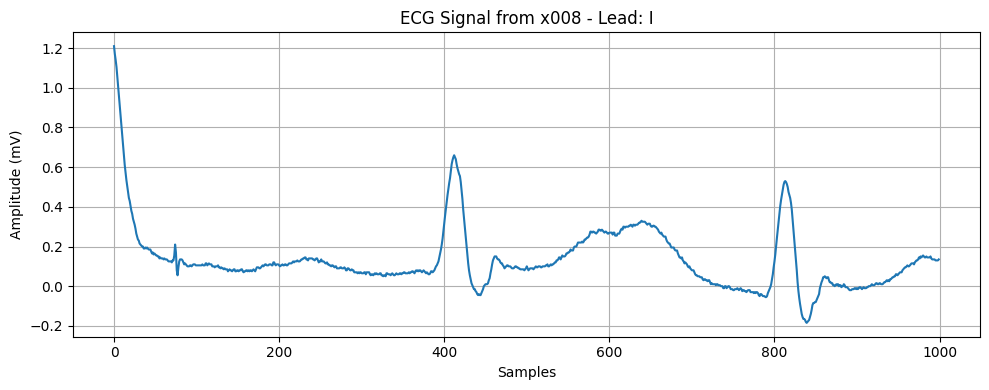

In [ ]:
import matplotlib.pyplot as plt
import os
import glob # Import glob to find files

rec_names = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(folder_path, '*.dat'))]

# Check if any record names were found before proceeding
if not rec_names:
    print(f"No record names found in {folder_path}. Please check the path and file types.")
else:
    # Select a record name to display
    record_name = rec_names[0]  # e.g., 'chf01'

    # Load the record
    record_path = os.path.join(folder_path, record_name)
    record = wfdb.rdrecord(record_path)

    # Plot the first few seconds of the first signal channel
    plt.figure(figsize=(10, 4))
    plt.plot(record.p_signal[:1000, 0])  # Plotting first 1000 samples from channel 0
    plt.title(f'ECG Signal from {record_name} - Lead: {record.sig_name[0]}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plot Sample ECG Signal with Annotations

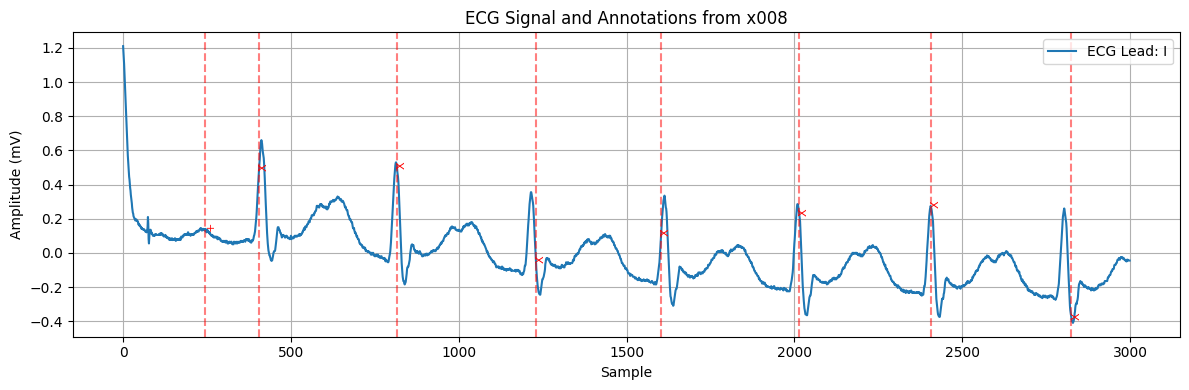

In [ ]:
import matplotlib.pyplot as plt
import wfdb

# Choose a record to display
record_name = rec_names[0]  # pick any record name
record_path = os.path.join(folder_path, record_name)

# Read the signal and annotations
record = wfdb.rdrecord(record_path)
try:
    annotation = wfdb.rdann(record_path, 'atr')  # 'atr' is the typical annotation extension
except FileNotFoundError:
    annotation = None
    print(f"No annotation found for {record_name}.")

# Plot the signal with annotations
plt.figure(figsize=(12, 4))
plt.plot(record.p_signal[:3000, 0], label='ECG Lead: ' + record.sig_name[0])
if annotation:
    ann_samples = annotation.sample
    ann_symbols = annotation.symbol
    for s, sym in zip(ann_samples, ann_symbols):
        if s < 3000:
            plt.axvline(x=s, color='red', linestyle='--', alpha=0.5)
            plt.text(s, record.p_signal[s, 0], sym, color='red', fontsize=8, rotation=90)
plt.title(f'ECG Signal and Annotations from {record_name}')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


# Data Preprocessing: Load Metadata, Define Leads/Labels, Prepare Save Folder

In [ ]:
import shutil

# Lead selection and label mappings
standard_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
chd_leads = ['II', 'III', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
original_label_map = {'N': 0, 'L': 1, 'R': 2, 'A': 3, 'V': 4, 'F': 5, '/': 6}
binary_label_map = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1}

# List of record filenames
rec_files = [f for f in os.listdir(folder_path) if f.endswith('.hea')]
rec_names = [os.path.splitext(f)[0] for f in rec_files]
print(f"Found {len(rec_names)} records.")

# Folder to save processed data
save_folder = './processed_chunks'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
os.makedirs(save_folder, exist_ok=True)

# Window size
window_duration_s = 1
chunk_idx = 0


Found 39 records.


Data Preprocessing: Define Bandpass Filter Function and Process Records (Iterate through records, Filter, Normalize, Window, Label, Save Chunks)

In [ ]:
from scipy.signal import butter, filtfilt
import gc

def bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, signal, axis=0)
    return filtered

# Your main loop
for rec in rec_names[:20]:  # Process first 20 records for testing
    path = os.path.join(folder_path, rec)
    try:
        record = wfdb.rdrecord(path)
        ann = wfdb.rdann(path, 'atr')
        fs = record.fs
        sig = record.p_signal
        leads = record.sig_name
        ann_samps = ann.sample
        ann_syms = ann.symbol

        try:
            idx = [leads.index(l) for l in chd_leads]
        except ValueError:
            print(f"⚠️ Missing some CHD leads in {rec}, skipping.")
            continue

        ecg_chd = sig[:, idx]

        # Apply bandpass filtering BEFORE normalization
        ecg_chd = bandpass_filter(ecg_chd, fs, lowcut=0.5, highcut=40.0, order=4)

        means = ecg_chd.mean(axis=0, keepdims=True)
        stds = ecg_chd.std(axis=0, keepdims=True)
        ecg_chd = (ecg_chd - means) / stds

        win_sz = int(window_duration_s * fs)
        n_windows = ecg_chd.shape[0] // win_sz
        trimmed = ecg_chd[:n_windows * win_sz, :]
        windows = trimmed.reshape(n_windows, win_sz, len(chd_leads))

        valid_ann = [(s, sym) for s, sym in zip(ann_samps, ann_syms) if s < n_windows * win_sz]
        if valid_ann:
            ann_samps_trim, ann_syms_trim = zip(*valid_ann)
        else:
            ann_samps_trim, ann_syms_trim = [], []

        chunk_windows = []
        chunk_labels = []
        labeled_windows = 0
        for w in range(n_windows):
            start, end = w * win_sz, (w + 1) * win_sz
            syms_in_window = [sym for s, sym in zip(ann_samps_trim, ann_syms_trim) if start <= s < end]
            lbls_in_window = [original_label_map.get(sym, -1) for sym in syms_in_window]
            lbls_in_window = [l for l in lbls_in_window if l >= 0]

            if lbls_in_window:
                orig_lbl = max(set(lbls_in_window), key=lbls_in_window.count)
                chunk_windows.append(windows[w])
                chunk_labels.append(orig_lbl)
                labeled_windows += 1

        print(f"{rec}: windows={n_windows}, labeled_windows={labeled_windows}")

        if len(chunk_windows) > 0:
            chunk_windows_np = np.stack(chunk_windows, axis=0)
            chunk_labels_np = np.array(chunk_labels, dtype=int)
            np.save(os.path.join(save_folder, f'X_chunk_{chunk_idx}.npy'), chunk_windows_np)
            np.save(os.path.join(save_folder, f'y_chunk_{chunk_idx}.npy'), chunk_labels_np)
            chunk_idx += 1

        del record, ann, sig, ecg_chd, windows, chunk_windows_np, chunk_labels_np
        gc.collect()

    except Exception as e:
        print(f" Error processing {rec}: {e}")
        continue

print(" Done processing and saving chunks.")
""

x008: windows=440, labeled_windows=309
x007: windows=186, labeled_windows=121
x009: windows=876, labeled_windows=93
x001: windows=8729, labeled_windows=7105
x108: windows=1509, labeled_windows=1268
x109: windows=635, labeled_windows=464
x0027: windows=77, labeled_windows=69
x0015: windows=194, labeled_windows=115
x100: windows=782, labeled_windows=668
x105: windows=1662, labeled_windows=1260
x106: windows=1066, labeled_windows=937
x002: windows=6317, labeled_windows=5143
x102: windows=1706, labeled_windows=1691
x0023: windows=395, labeled_windows=222
x0012: windows=699, labeled_windows=585
x005: windows=1856, labeled_windows=1839
x0013: windows=234, labeled_windows=184
x0024: windows=721, labeled_windows=489
x0011: windows=717, labeled_windows=25
x0017: windows=207, labeled_windows=64
 Done processing and saving chunks.


''

Lead Selection: Filtering the ECG data to include only specific leads relevant to Congenital Heart Disease (CHD).

Filtering: Applying a bandpass filter to remove noise and baseline wander from the selected signals.

Normalization: Standardizing the amplitude of the filtered signals lead-wise by removing the mean and scaling by the standard deviation.

Windowing: Dividing the continuous ECG signals into fixed-duration segments (windows).

Annotation-based Labeling: Assigning a class label to each window based on the most frequent type of heart beat annotation present within that window, and then mapping these to a binary classification label (e.g., normal vs. abnormal)


In [ ]:

#  Load Processed Chunks and Combine

X_list = []
y_list = []

for X_file in sorted(glob.glob(f'{save_folder}/X_chunk_*.npy')):
    y_file = X_file.replace('X_chunk_', 'y_chunk_')
    X_chunk = np.load(X_file)
    y_chunk = np.load(y_file)
    X_list.append(X_chunk)
    y_list.append(y_chunk)

X = np.concatenate(X_list, axis=0)
y_original = np.concatenate(y_list, axis=0)
y_chd = np.vectorize(binary_label_map.get)(y_original)

print(" Combined data shape:", X.shape)
print(" Original labels count:", np.unique(y_original, return_counts=True))
print(" Binary CHD labels count:", np.unique(y_chd, return_counts=True))

 Combined data shape: (22651, 977, 9)
 Original labels count: (array([0, 2, 3, 4, 5, 6]), array([14655,  5468,   252,   656,    66,  1554]))
 Binary CHD labels count: (array([0, 1]), array([20123,  2528]))


Features are saved as X_chunk_{chunk_idx}.npy

Labels are saved as y_chunk_{chunk_idx}.npy

Train / Validation / Test Split


In [ ]:
# Train / Validation / Test Split

from sklearn.model_selection import train_test_split

# 1) Train vs Temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_chd,
    test_size=0.3,
    random_state=42,
    stratify=y_chd
)

# 2) Validation vs Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f" Train shape:      {X_train.shape},  labels: {np.unique(y_train, return_counts=True)}")
print(f" Validation shape: {X_val.shape},  labels: {np.unique(y_val, return_counts=True)}")
print(f" Test shape:       {X_test.shape},  labels: {np.unique(y_test, return_counts=True)}")


 Train shape:      (15855, 977, 9),  labels: (array([0, 1]), array([14085,  1770]))
 Validation shape: (3398, 977, 9),  labels: (array([0, 1]), array([3019,  379]))
 Test shape:       (3398, 977, 9),  labels: (array([0, 1]), array([3019,  379]))


# Build ResNet18 1D Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Define ResNet18-1D
def build_resnet18_1d(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model


Train with Two Optimizers

In [ ]:
input_shape = X_train.shape[1:]
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -------- SGD Optimizer --------
sgd_model = build_resnet18_1d(input_shape)
sgd_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history_sgd = sgd_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=20, batch_size=32, callbacks=[early_stop])



Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.9030 - loss: 0.2665 - val_accuracy: 0.9629 - val_loss: 0.0938
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1234s 2s/step - accuracy: 0.9634 - loss: 0.1023 - val_accuracy: 0.9756 - val_loss: 0.0781
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.9723 - loss: 0.0795 - val_accuracy: 0.9768 - val_loss: 0.0731
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1224s 2s/step - accuracy: 0.9755 - loss: 0.0677 - val_accuracy: 0.9800 - val_loss: 0.0566
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1210s 2s/step - accuracy: 0.9786 - loss: 0.0615 - val_accuracy: 0.9782 - val_loss: 0.0566
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1300s 3s/step - accuracy: 0.9804 - loss: 0.0548 - val_accuracy: 0.9773 - val_loss: 0.0623
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1195s 2s/step - accuracy: 0.9840 - loss: 0.0458 - val_accuracy: 0.9859 - val_loss: 0.0458
Epoch 8/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1262s 2s/step - accuracy: 0.9857 - loss: 0.0390 - 

In [ ]:
# Evaluate SGD model
sgd_test_loss, sgd_test_accuracy = sgd_model.evaluate(X_test, y_test, verbose=1)
print("🔹 SGD Optimizer:")
print(f"Test Loss     : {sgd_test_loss:.4f}")
print(f"Test Accuracy : {sgd_test_accuracy:.4f}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 46s 425ms/step - accuracy: 0.9907 - loss: 0.0287
🔹 SGD Optimizer:
Test Loss     : 0.0311
Test Accuracy : 0.9885


In [ ]:
# -------- Adam Optimizer --------
adam_model = build_resnet18_1d(input_shape)
adam_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_adam = adam_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=20, batch_size=32, callbacks=[early_stop])


Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1231s 2s/step - accuracy: 0.9137 - loss: 0.2473 - val_accuracy: 0.9623 - val_loss: 0.1254
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1193s 2s/step - accuracy: 0.9626 - loss: 0.1119 - val_accuracy: 0.9670 - val_loss: 0.0907
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1235s 2s/step - accuracy: 0.9675 - loss: 0.0897 - val_accuracy: 0.9756 - val_loss: 0.0718
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1200s 2s/step - accuracy: 0.9704 - loss: 0.0849 - val_accuracy: 0.9773 - val_loss: 0.0636
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1222s 2s/step - accuracy: 0.9742 - loss: 0.0763 - val_accuracy: 0.9806 - val_loss: 0.0559
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1222s 2s/step - accuracy: 0.9766 - loss: 0.0631 - val_accuracy: 0.9467 - val_loss: 0.1469
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1222s 2s/step - accuracy: 0.9796 - loss: 0.0618 - val_accuracy: 0.9820 - val_loss: 0.0481
Epoch 8/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.9819 - loss: 0.0510 - 

Evaluate ResNet18 1D Model

In [ ]:
# Evaluate SGD model
sgd_test_loss, sgd_test_accuracy = sgd_model.evaluate(X_test, y_test, verbose=1)
print("🔹 SGD Optimizer:")
print(f"Test Loss     : {sgd_test_loss:.4f}")
print(f"Test Accuracy : {sgd_test_accuracy:.4f}")

# Evaluate Adam model
adam_test_loss, adam_test_accuracy = adam_model.evaluate(X_test, y_test, verbose=1)
print("\n🔹 Adam Optimizer:")
print(f"Test Loss     : {adam_test_loss:.4f}")
print(f"Test Accuracy : {adam_test_accuracy:.4f}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 47s 438ms/step - accuracy: 0.9907 - loss: 0.0287
🔹 SGD Optimizer:
Test Loss     : 0.0311
Test Accuracy : 0.9885
107/107 ━━━━━━━━━━━━━━━━━━━━ 45s 423ms/step - accuracy: 0.9886 - loss: 0.0326

🔹 Adam Optimizer:
Test Loss     : 0.0349
Test Accuracy : 0.9879


In [ ]:
#Store results in a dictionary for comparison
results = {
    "SGD": {"loss": sgd_test_loss, "accuracy": sgd_test_accuracy},
    "Adam": {"loss": adam_test_loss, "accuracy": adam_test_accuracy}
}

Plot ResNet18 1D Model Accuracy and Loss

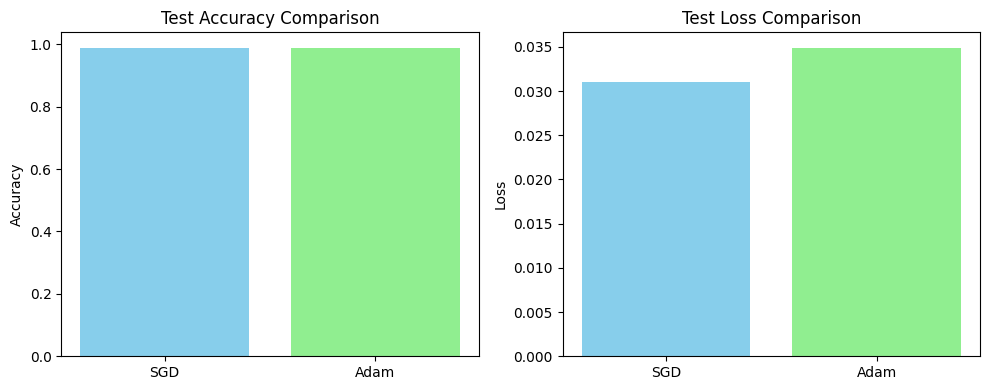

In [ ]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Adam']
accuracies = [sgd_test_accuracy, adam_test_accuracy]
losses = [sgd_test_loss, adam_test_loss]

plt.figure(figsize=(10, 4))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(labels, accuracies, color=['skyblue', 'lightgreen'])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")

# Loss comparison
plt.subplot(1, 2, 2)
plt.bar(labels, losses, color=['skyblue', 'lightgreen'])
plt.title("Test Loss Comparison")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


Confusion Matrix for ResNet18 1D

107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 494ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 48s 438ms/step


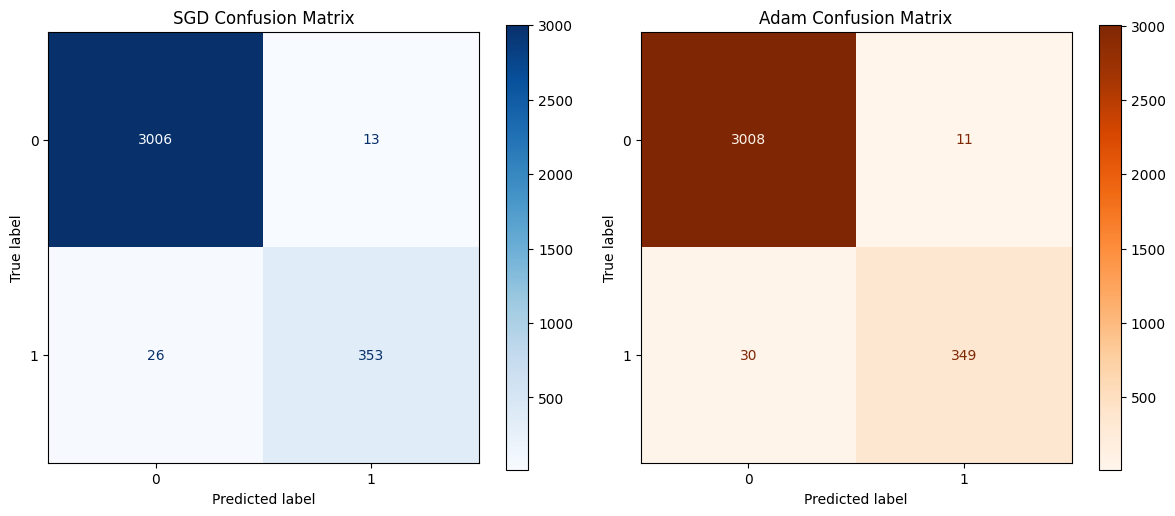

Classification Report (SGD):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3019
           1       0.96      0.93      0.95       379

    accuracy                           0.99      3398
   macro avg       0.98      0.96      0.97      3398
weighted avg       0.99      0.99      0.99      3398

Classification Report (Adam):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3019
           1       0.97      0.92      0.94       379

    accuracy                           0.99      3398
   macro avg       0.98      0.96      0.97      3398
weighted avg       0.99      0.99      0.99      3398



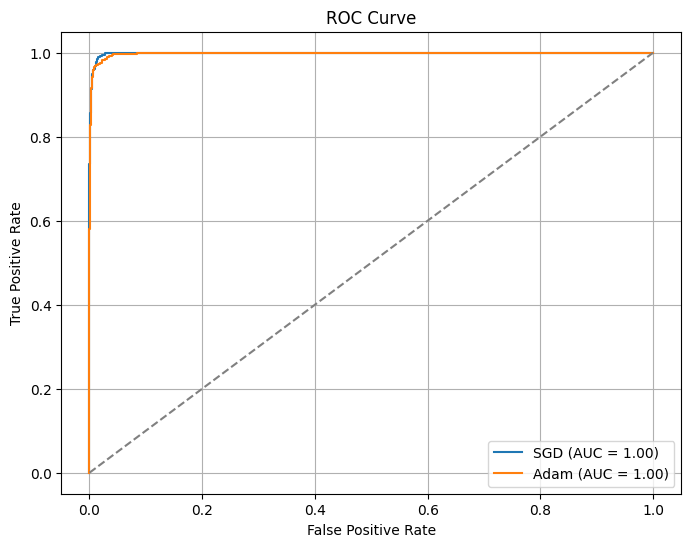

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
# Corrected variable name from resnet18_1d_sgd_model to sgd_model
y_pred_proba_sgd = sgd_model.predict(X_test)
y_pred_sgd = (y_pred_proba_sgd > 0.5).astype("int32")

# Corrected variable name from resnet18_1d_adam_model to adam_model
y_pred_proba_adam = adam_model.predict(X_test)
y_pred_adam = (y_pred_proba_adam > 0.5).astype("int32")

# ------------------ CONFUSION MATRICES ------------------
cm_sgd = confusion_matrix(y_test, y_pred_sgd)
cm_adam = confusion_matrix(y_test, y_pred_adam)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_sgd, display_labels=[0, 1]).plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title("SGD Confusion Matrix")

ConfusionMatrixDisplay(cm_adam, display_labels=[0, 1]).plot(ax=ax[1], cmap=plt.cm.Oranges)
ax[1].set_title("Adam Confusion Matrix")

plt.tight_layout()
plt.show()

# ------------------ CLASSIFICATION REPORTS ------------------
print("Classification Report (SGD):")
print(classification_report(y_test, y_pred_sgd))

print("Classification Report (Adam):")
print(classification_report(y_test, y_pred_adam))

# ------------------ ROC CURVE (Optional) ------------------
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_proba_sgd)
fpr_adam, tpr_adam, _ = roc_curve(y_test, y_pred_proba_adam)

auc_sgd = auc(fpr_sgd, tpr_sgd)
auc_adam = auc(fpr_adam, tpr_adam)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, label=f"SGD (AUC = {auc_sgd:.2f})")
plt.plot(fpr_adam, tpr_adam, label=f"Adam (AUC = {auc_adam:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# --- ResNet18 (SGD and Adam) ---
# Assuming you have y_test, y_pred_sgd, and y_pred_adam from previous steps
print("Classification Report (ResNet18 - SGD):")
print(classification_report(y_test, y_pred_sgd))

print("Classification Report (ResNet18 - Adam):")
print(classification_report(y_test, y_pred_adam))


Classification Report (ResNet18 - SGD):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3019
           1       0.96      0.93      0.95       379

    accuracy                           0.99      3398
   macro avg       0.98      0.96      0.97      3398
weighted avg       0.99      0.99      0.99      3398

Classification Report (ResNet18 - Adam):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3019
           1       0.97      0.92      0.94       379

    accuracy                           0.99      3398
   macro avg       0.98      0.96      0.97      3398
weighted avg       0.99      0.99      0.99      3398



# Define the ResNet50-1D model function



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Bottleneck block
def bottleneck_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    bottleneck_filters = filters // 4

    x = Conv1D(bottleneck_filters, 1, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(bottleneck_filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, 1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# ResNet50-1D
def build_resnet50_1d(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ResNet Blocks
    for _ in range(3): x = bottleneck_block(x, 256, stride=1)
    x = bottleneck_block(x, 512, stride=2)
    for _ in range(3): x = bottleneck_block(x, 512)
    x = bottleneck_block(x, 1024, stride=2)
    for _ in range(5): x = bottleneck_block(x, 1024)
    x = bottleneck_block(x, 2048, stride=2)
    for _ in range(2): x = bottleneck_block(x, 2048)

    # Final layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)


 Train ResNet50 without augmentation

In [ ]:
model_no_aug = build_resnet50_1d(X_train.shape[1:])
model_no_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_no_aug = model_no_aug.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3242s 6s/step - accuracy: 0.9251 - loss: 0.2843 - val_accuracy: 0.9597 - val_loss: 0.1138
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3294s 7s/step - accuracy: 0.9623 - loss: 0.1042 - val_accuracy: 0.9626 - val_loss: 0.1075
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3217s 6s/step - accuracy: 0.9707 - loss: 0.0877 - val_accuracy: 0.9588 - val_loss: 0.1155
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3252s 7s/step - accuracy: 0.9719 - loss: 0.0859 - val_accuracy: 0.9703 - val_loss: 0.0779
Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3263s 7s/step - accuracy: 0.9685 - loss: 0.0825 - val_accuracy: 0.9564 - val_loss: 0.1516
Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3254s 6s/step - accuracy: 0.9747 - loss: 0.0743 - val_accuracy: 0.9665 - val_loss: 0.0983
Epoch 7/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3279s 7s/step - accuracy: 0.9759 - loss: 0.0694 - val_accuracy: 0.9756 - val_loss: 0.0698
Epoch 8/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 3243s 6s/step - accuracy: 0.9798 - loss: 0.0597 - 

In [ ]:
# Get training history
train_loss = history_no_aug.history['loss']
train_accuracy = history_no_aug.history['accuracy']
val_loss = history_no_aug.history['val_loss']
val_accuracy = history_no_aug.history['val_accuracy']

# Evaluate the model on the test set
test_loss, test_accuracy = model_no_aug.evaluate(X_test, y_test, verbose=0)

# Print the results
print(f"Training Accuracy (last epoch): {train_accuracy[-1]:.4f}")
print(f"Training Loss (last epoch): {train_loss[-1]:.4f}")
print(f"Validation Accuracy (best epoch): {val_accuracy[np.argmin(val_loss)]:.4f}") # Get accuracy at the epoch with best validation loss
print(f"Validation Loss (best epoch): {np.min(val_loss):.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

Training Accuracy (last epoch): 0.9830
Training Loss (last epoch): 0.0539
Validation Accuracy (best epoch): 0.9859
Validation Loss (best epoch): 0.0457
Testing Accuracy: 0.9838
Testing Loss: 0.0445


107/107 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step
Confusion Matrix for ResNet50 1D:
[[3006   13]
 [  42  337]]


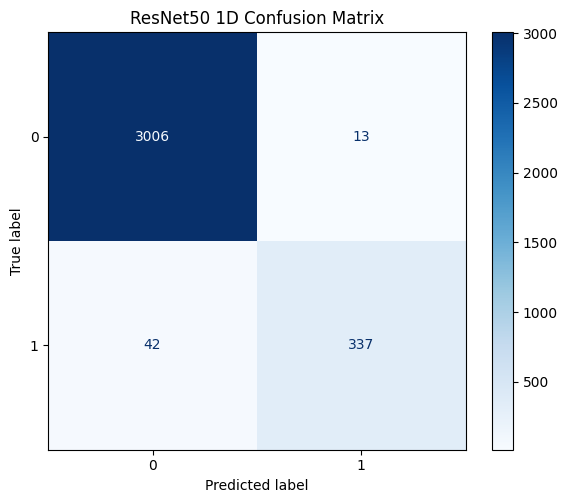

Classification Report (ResNet50 1D):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3019
           1       0.96      0.89      0.92       379

    accuracy                           0.98      3398
   macro avg       0.97      0.94      0.96      3398
weighted avg       0.98      0.98      0.98      3398



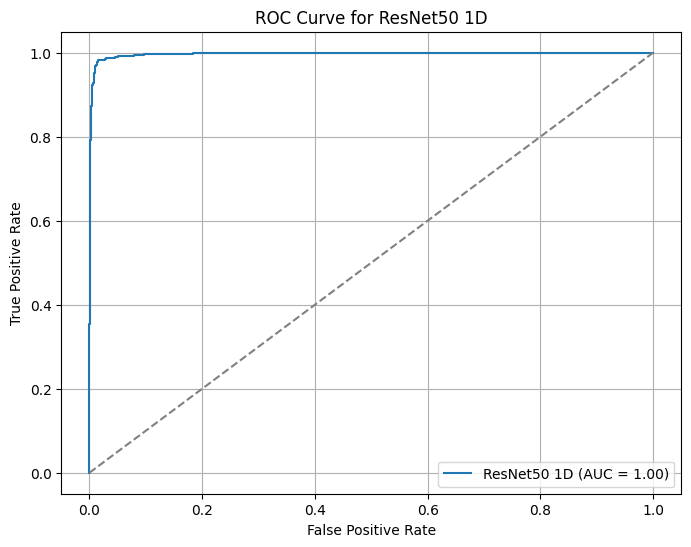

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model_no_aug' is your trained ResNet50 1D model
# Get predictions on the test set
y_pred_proba_resnet50 = model_no_aug.predict(X_test)
y_pred_resnet50 = (y_pred_proba_resnet50 > 0.5).astype("int32")

# ------------------ CONFUSION MATRIX ------------------
cm_resnet50 = confusion_matrix(y_test, y_pred_resnet50)

print("Confusion Matrix for ResNet50 1D:")
print(cm_resnet50)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(cm_resnet50, display_labels=[0, 1]).plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title("ResNet50 1D Confusion Matrix")
plt.tight_layout()
plt.show()

# ------------------ CLASSIFICATION REPORT ------------------
print("Classification Report (ResNet50 1D):")
print(classification_report(y_test, y_pred_resnet50))

# ------------------ ROC CURVE ------------------
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, y_pred_proba_resnet50)
auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

plt.figure(figsize=(8, 6))
plt.plot(fpr_resnet50, tpr_resnet50, label=f"ResNet50 1D (AUC = {auc_resnet50:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ResNet50 1D")
plt.legend()
plt.grid(True)
plt.show()

# Build LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Dynamically get the input shape from the training data
# X_train shape is (batch_size, timesteps, features)
# We need (timesteps, features) for the input layer
# Ensure X_train is defined before this part in your notebook
input_shape = X_train.shape[1:]

lstm_model = Sequential()
# Add the first LSTM layer, return_sequences=True to output sequences
lstm_model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
# Add Dropout after the first LSTM
lstm_model.add(Dropout(0.4))
# Add a second LSTM layer, no return_sequences=True as it's not followed by another LSTM
lstm_model.add(LSTM(32, return_sequences=False)) # You can adjust the number of units
# Add Dropout after the second LSTM
lstm_model.add(Dropout(0.3))
# Add a Dense layer
lstm_model.add(Dense(64, activation='tanh'))
# Add another Dropout layer
lstm_model.add(Dropout(0.2))
# Output layer
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 977, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 977, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

Train LSTM Model

In [ ]:

# %%
# Train the LSTM model
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# Make sure X_train, y_train, X_val, and y_val are available from your data splitting
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,  # You can adjust the number of epochs
    batch_size=32, # You can adjust the batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stop] # Add the early stopping callback
)


Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 272s 543ms/step - accuracy: 0.8748 - loss: 0.3776 - val_accuracy: 0.8982 - val_loss: 0.3198
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 339s 578ms/step - accuracy: 0.8969 - loss: 0.3128 - val_accuracy: 0.8893 - val_loss: 0.3135
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 325s 585ms/step - accuracy: 0.8997 - loss: 0.2934 - val_accuracy: 0.8932 - val_loss: 0.3219
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 318s 576ms/step - accuracy: 0.8951 - loss: 0.3250 - val_accuracy: 0.9011 - val_loss: 0.2957
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 332s 596ms/step - accuracy: 0.9118 - loss: 0.2731 - val_accuracy: 0.9029 - val_loss: 0.2738
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 331s 615ms/step - accuracy: 0.9159 - loss: 0.2576 - val_accuracy: 0.9264 - val_loss: 0.2520
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 311s 593ms/step - accuracy: 0.9251 - loss: 0.2525 - val_accuracy: 0.9273 - val_loss: 0.2469
Epoch 8/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 323s 594ms/step - accuracy: 0.9306 -

Evaluate LSTM Model

Plot LSTM Model Accuracy and Loss

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9139 - loss: 0.2595
LSTM Test Loss: 0.2506
LSTM Test Accuracy: 0.9158


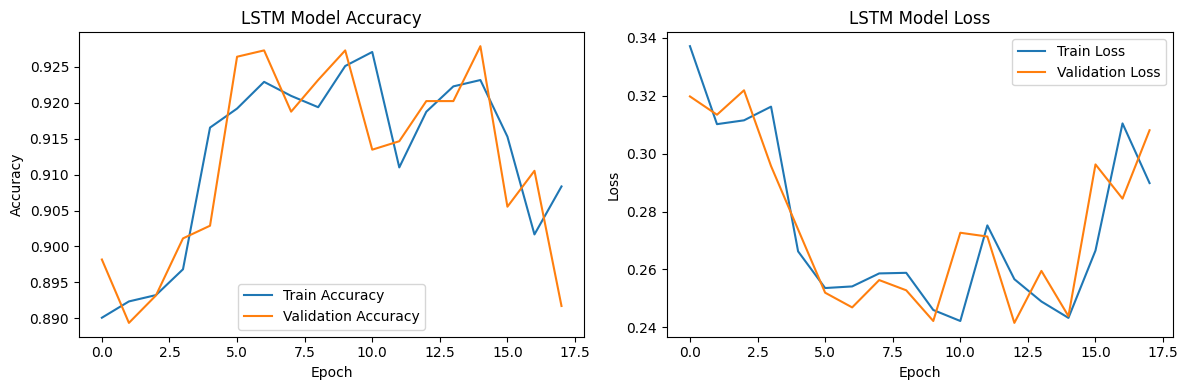

In [ ]:

# %%
# Evaluate the LSTM model on the test set
test_loss_lstm, test_accuracy_lstm = lstm_model.evaluate(X_test, y_test, verbose=1)

print(f"LSTM Test Loss: {test_loss_lstm:.4f}")
print(f"LSTM Test Accuracy: {test_accuracy_lstm:.4f}")

# %%
import matplotlib.pyplot as plt

# Make sure the history_lstm object from training is available

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step
Confusion Matrix for LSTM Model:
[[2948   71]
 [ 215  164]]


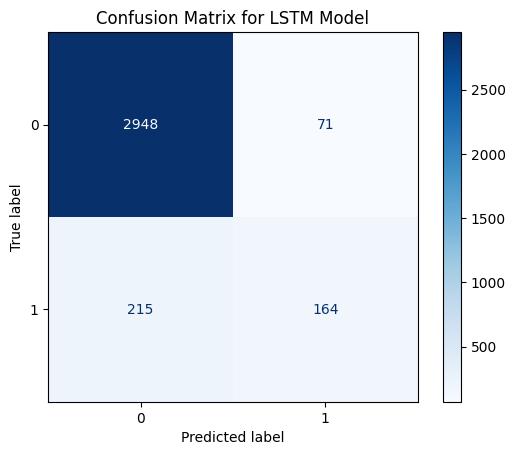

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt # Make sure plt is imported

# Get predictions on the test set using the 'lstm_model'
# Since your output layer uses 'sigmoid' activation for binary classification,
# the output is a probability between 0 and 1.
# We need to convert these probabilities to binary class labels (0 or 1).
# A common threshold is 0.5.
y_pred_proba_lstm = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype("int32")

# Generate the confusion matrix for the LSTM model
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

print("Confusion Matrix for LSTM Model:")
print(cm_lstm)

# Create and plot the Confusion Matrix Display
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=[0, 1])

# Plot the confusion matrix
disp_lstm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [ ]:
# --- LSTM Model ---
# Assuming you have y_test and lstm_model from the LSTM section
# You'll need to generate predictions for the LSTM model first
y_pred_proba_lstm = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype("int32")

print("Classification Report (LSTM):")
print(classification_report(y_test, y_pred_lstm))

107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step
Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3019
           1       0.70      0.43      0.53       379

    accuracy                           0.92      3398
   macro avg       0.81      0.70      0.74      3398
weighted avg       0.91      0.92      0.91      3398

